## Topic 2: Performance Metrics and Scalability Analysis in Simulations

This topic focuses on evaluating simulation results using key metrics and analysng how network performance scales with size and hardware quality. Metrics help identify bottlenecks, while scalability analysis predicts real-world feasibility.

**Key Concepts:**

**Fidelity:** Measures entanglement quality (0–1); degrades with noise/decoherence. Modeled as initial fidelity per link, reduced by a degradation factor per swap.

**Latency:** Time from request to delivery. Estimated as average time over successful trials, assuming a base time per attempt (e.g., 1 ms per link/swap attempt).

**Throughput:** Pairs per unit time (e.g., pairs/sec). Calculated as success probability divided by average latency.

**Scalability:** How metrics change with more nodes, longer distances, or worse hardware.

The code below extends the Topic 1 simulation to measure success probability, fidelity, latency, and throughput. It analyses scalability by varying path length (number of links) from 1 to 10, runs trials, and plots results. 

**Step 1: Import necessary libraries**

In [1]:
import random
import matplotlib.pyplot as plt
from sequence.kernel.timeline import Timeline
from sequence.topology.node import QuantumRouter, BSMNode
from sequence.components.memory import Memory
from sequence.components.optical_channel import QuantumChannel, ClassicalChannel
from sequence.entanglement_management.generation import EntanglementGenerationA
from sequence.entanglement_management.swapping import EntanglementSwappingA

**Step 2: Define Simulation Parameters**

We'll define the physical parameters of our network components. These probabilities will determine the success of our operations.

In [2]:
# Simulation parameters
PLINK = 0.5  # Probability of success for each elementary link generation
PSWAP = 0.8  # Probability of success for each entanglement swap
INITIAL_FIDELITY = 0.99  # Starting fidelity per link
DEGRADATION_FACTOR = 0.99  # Fidelity degradation per swap
TIME_PER_ATTEMPT_PS = 1e9  # Assumed base time per link/swap attempt (1 ms in picoseconds)

**Step 3: Build the quantum network for number of links**

We'll define a function which will :

1. Create node objects: Alice, Node 1, Node 2, ..... Node i, Bob

2. Intitailse the simulation time

3. Create routers and memories 

4. Configure the quantum memory on internediate nodes and connect the nodes with QuantumChannel objects.

5. Define and assign protocols 

In [3]:
# Function to build network for variable number of links (hops)
def build_network(num_links):
    path = ['Alice'] + [f'Node{i}' for i in range(1, num_links)] + ['Bob']
    
    tl = Timeline(1e12)  # 1 second simulation time
    
    # Create routers and memories
    routers = []
    memories = []
    for name in path:
        router = QuantumRouter(name, tl)
        mem = Memory(f"{name}_mem", tl, fidelity=INITIAL_FIDELITY, frequency=0, efficiency=1.0, coherence_time=-1, wavelength=500)
        router.add_component(mem)
        routers.append(router)
        memories.append(mem)
    
    # For intermediate nodes, add extra memory for swapping
    for i in range(1, num_links):
        extra_mem = Memory(f"{path[i]}_extra_mem", tl, fidelity=INITIAL_FIDELITY, frequency=0, efficiency=1.0, coherence_time=-1, wavelength=500)
        routers[i].add_component(extra_mem)
        memories.append(extra_mem)
    
    # Create BSM nodes and channels (simplified)
    bsm_nodes = []
    for i in range(num_links):
        bsm = BSMNode(f"BSM{i}", tl, [path[i], path[i+1]])
        bsm_nodes.append(bsm)
        
        qc1 = QuantumChannel(f"qc_{i}_1", tl, distance=1e3, attenuation=0)
        qc1.set_ends(routers[i], bsm.name)
        qc2 = QuantumChannel(f"qc_{i}_2", tl, distance=1e3, attenuation=0)
        qc2.set_ends(routers[i+1], bsm.name)
    
    # Classical channels (simplified mesh)
    for i in range(len(routers)):
        for j in range(i+1, len(routers)):
            cc = ClassicalChannel(f"cc_{i}_{j}", tl, distance=1e3, delay=1e6)
            cc.set_ends(routers[i], routers[j])
    
    # Protocols (simplified for variable length)
    gen_protocols = []
    swap_protocols = []
    for i in range(num_links):
        gen_a = EntanglementGenerationA(routers[i], f"gen_{i}", bsm_nodes[i].name, routers[i+1].name, memories[i])
        gen_b = EntanglementGenerationA(routers[i+1], f"gen_{i+1}", bsm_nodes[i].name, routers[i].name, memories[i+1])
        gen_protocols.extend([gen_a, gen_b])
    
    for i in range(1, num_links):
        swap = EntanglementSwappingA(routers[i], f"swap_{i}", memories[i], memories[i+1], success_prob=PSWAP)
        swap_protocols.append(swap)
    
    # Assign protocols
    for router, gen in zip(routers, gen_protocols):
        router.protocols.append(gen)
    for router, swap in zip(routers[1:num_links], swap_protocols):
        router.protocols.append(swap)
    
    return tl, gen_protocols, swap_protocols

**Step 4: Run the simulation**

We define a function to run the simulation over the timeline and protocols defined earlier. This function first intialise the simulation, start generation protocols to run over the timeline, check for links (connected nodes), simulate swaps, and then calculate fidelity. It will return latency and fidelity. 

In [4]:
# Function to simulate one attempt for a given number of links
def run_attempt(num_links, verbose=False):
    tl, gen_protocols, swap_protocols = build_network(num_links)
    tl.init()
    
    start_time = tl.time
    
    # Start generation protocols
    for gen in gen_protocols:
        gen.start()
    
    tl.run()
    
    # Probabilistic check for links (override to avoid state issues)
    link_success = random.random() < PLINK**num_links
    if verbose:
        print("Links OK" if link_success else "Link failure")
    if not link_success:
        return "FAILURE", (tl.time - start_time) / 1e9, 0.0  # latency in ms, fidelity 0
    
    # Simulate swaps without calling start() to avoid assertion (use probabilistic)
    swap_success = random.random() < PSWAP**(num_links - 1)
    if verbose:
        print("Swaps OK" if swap_success else "Swap failure")
    if not swap_success:
        return "FAILURE", (tl.time - start_time) / 1e9, 0.0
    
    # Calculate fidelity
    fidelity = (INITIAL_FIDELITY ** num_links) * (DEGRADATION_FACTOR ** (num_links - 1))
    
    latency_ms = (tl.time - start_time) / 1e9  # convert ps to ms
    return "SUCCESS", latency_ms, fidelity


**Step 5: Measure performance metrics**

We define a function that will return end-to-end success probability, average latency, average fidelity and throughput over a number of trials. 


In [5]:
# Measure Success Probability, Fidelity, Latency, Throughput for a fixed path length
def measure_success_probability(num_links, trials=10000):
    successes = 0
    total_latency_ms = 0.0
    total_fidelity = 0.0
    for _ in range(trials):
        result, latency, fidelity = run_attempt(num_links)
        if result == "SUCCESS":
            successes += 1
            total_latency_ms += latency
            total_fidelity += fidelity
    
    p_end_to_end = successes / trials
    theoretical = (PLINK ** num_links) * (PSWAP ** (num_links - 1)) if num_links > 0 else 1.0
    avg_latency_ms = total_latency_ms / successes if successes > 0 else 0.0
    avg_fidelity = total_fidelity / successes if successes > 0 else 0.0
    throughput = (p_end_to_end * 1000) / avg_latency_ms if avg_latency_ms > 0 else 0.0  # pairs per second (ms to s)
    
    print(f"Path length (links): {num_links}")
    print(f"Measured End-to-End Success Probability: {p_end_to_end:.4f} (theoretical: {theoretical:.4f})")
    print(f"Average Latency (ms): {avg_latency_ms:.4f}")
    print(f"Average Fidelity: {avg_fidelity:.4f}")
    print(f"Throughput (pairs/sec): {throughput:.4f}\n")
    
    return p_end_to_end, theoretical, avg_latency_ms, avg_fidelity, throughput

**Step 6: Scalability Analysis**

Call this function for different path lengths (e.g., N=1, 2, 3, ... 10 links).

Store the results.

In [6]:
# Analyse Scalability: Vary path length from 1 to 10 links
path_lengths = list(range(1, 11))
measured_probs = []
theoretical_probs = []
latencies = []
fidelities = []
throughputs = []

for num_links in path_lengths:
    p_meas, p_theor, lat, fid, thr = measure_success_probability(num_links)
    measured_probs.append(p_meas)
    theoretical_probs.append(p_theor)
    latencies.append(lat)
    fidelities.append(fid)
    throughputs.append(thr)

Path length (links): 1
Measured End-to-End Success Probability: 0.5072 (theoretical: 0.5000)
Average Latency (ms): 0.0000
Average Fidelity: 0.9900
Throughput (pairs/sec): 0.0000

Path length (links): 2
Measured End-to-End Success Probability: 0.1965 (theoretical: 0.2000)
Average Latency (ms): 0.0000
Average Fidelity: 0.9703
Throughput (pairs/sec): 0.0000

Path length (links): 3
Measured End-to-End Success Probability: 0.0785 (theoretical: 0.0800)
Average Latency (ms): 0.0000
Average Fidelity: 0.9510
Throughput (pairs/sec): 0.0000

Path length (links): 4
Measured End-to-End Success Probability: 0.0335 (theoretical: 0.0320)
Average Latency (ms): 0.0000
Average Fidelity: 0.9321
Throughput (pairs/sec): 0.0000

Path length (links): 5
Measured End-to-End Success Probability: 0.0125 (theoretical: 0.0128)
Average Latency (ms): 0.0000
Average Fidelity: 0.9135
Throughput (pairs/sec): 0.0000

Path length (links): 6
Measured End-to-End Success Probability: 0.0053 (theoretical: 0.0051)
Average Late

**Step 7: Visualise the Data**

Plot your results with the "Number of Hops" (i.e., path length) on the x-axis and "Success Probability" on the y-axis.

You should see a curve that drops off very quickly. This graph powerfully illustrates the fundamental challenge of building large-scale quantum networks and motivates the need for more advanced technologies like quantum repeaters.

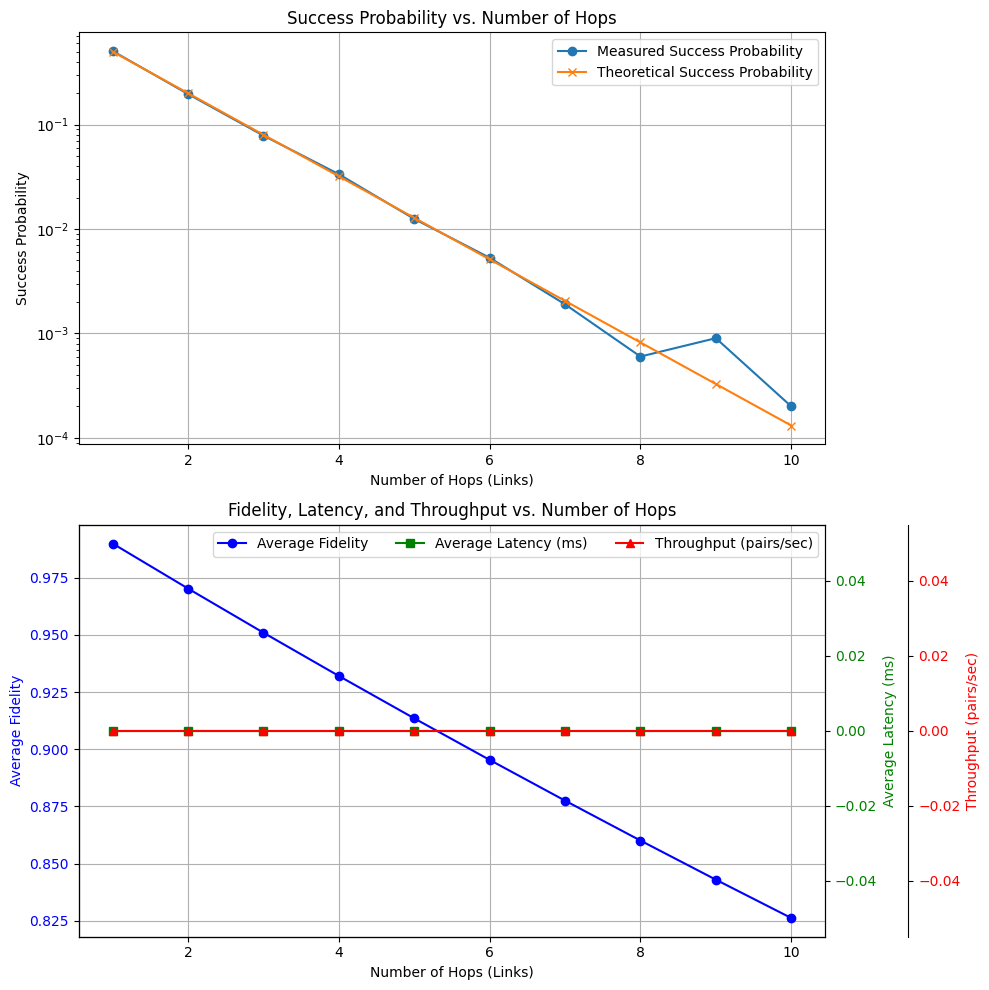

In [10]:
# Visualize the Data
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot Success Probability
axs[0].plot(path_lengths, measured_probs, label='Measured Success Probability', marker='o')
axs[0].plot(path_lengths, theoretical_probs, label='Theoretical Success Probability', marker='x')
axs[0].set_xlabel('Number of Hops (Links)')
axs[0].set_ylabel('Success Probability')
axs[0].set_title('Success Probability vs. Number of Hops')
axs[0].legend()
axs[0].grid(True)
axs[0].set_yscale('log')

# Plot Fidelity, Latency, and Throughput
axs[1].plot(path_lengths, fidelities, 'b-o', label='Average Fidelity')
axs[1].set_xlabel('Number of Hops (Links)')
axs[1].set_ylabel('Average Fidelity', color='b')
axs[1].tick_params(axis='y', labelcolor='b')

ax2 = axs[1].twinx()
ax2.plot(path_lengths, latencies, 'g-s', label='Average Latency (ms)')
ax2.set_ylabel('Average Latency (ms)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

ax3 = axs[1].twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(path_lengths, throughputs, 'r-^', label='Throughput (pairs/sec)')
ax3.set_ylabel('Throughput (pairs/sec)', color='r')
ax3.tick_params(axis='y', labelcolor='r')

axs[1].set_title('Fidelity, Latency, and Throughput vs. Number of Hops')
lines1, labels1 = axs[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
axs[1].legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper right', ncol =3)
axs[1].grid(True)

plt.tight_layout()
plt.show()